# String Method Analysis Markov-State-Models
## Imports

In [3]:
import os
import pickle
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt


logging.getLogger("stringmethod").setLevel(logging.ERROR)
sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

['/data2/GLUT5_string/string/analysis/scripts', '/home/semccomas/anaconda3/envs/string_method/lib/python38.zip', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/lib-dynload', '', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages', '../string-method-gmxapi/', '../../string-method-gmxapi/', '../../string-method-gmxapi/stringmethod/simulations/../../']


## Load data

This notebook needs to run in the string simulation folder, this cell will get you there. You also set up a path for writing the figures.

In [4]:
name_sim = "influx_BFRU_gate_CV"
simulation_directory = f"../../string_sims/TMD_initial_path/{name_sim}/"
path_report = f"../images_figs/MSM_FES/{name_sim}"
os.chdir(simulation_directory)
os.getcwd()

'/data2/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV'

In [5]:
with open("cv.pkl", "rb") as file:
    cvs, ndx_groups = pickle.load(file)

The `load_swarm_data` function will load the swarm data in the `cv_coordinates`. If you set `extract=True` it will read the data from the swarm files. If you have done this previously you can set `extract=False` so the function just reads `postprocessing/cv_coordinates.npy`. `first_iteration` can be used to exclude initial swarms as equilibration and `last_iteration` can be done to exclude some iterations for example if you want to estimate the FES convergence by comparing blocks of data.

In [6]:
cv_coordinates = my_msm.load_swarm_data(
    extract=False, first_iteration=100, last_iteration=None
)

## Dimensionality reduction with TICA

The following cell computes the tica projection of the string cvs and discards the tics that have the lowest kinetic variance. This reduces the cvs space to a lower dimensional space that is adapted to the kinetic variance. You can use the drop keyword to drop certain cvs that are not well converged in the string simulation or that change very little from the beggining to the end of the string. The best case scenario is that `drop=[]` just works.

In [7]:
tica = my_msm.cvs_to_tica(cv_coordinates, drop=[])

## Cluster

The next cell plots the "vamp score" of using `n_clustercenters` to make an MSM. You should find that at some point the vamp score saturates. Choose the minimum number of clusters that gives you the saturated vamp score as the value of k for the next steps. This might take a little while.

/data2/GLUT5_string/string/analysis/scripts/string_tica_msm.py:85: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loop over k::   0%|          | 0/8 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Loop over iterations::   0%|          | 0/5 [00:00<?, ?it/s]

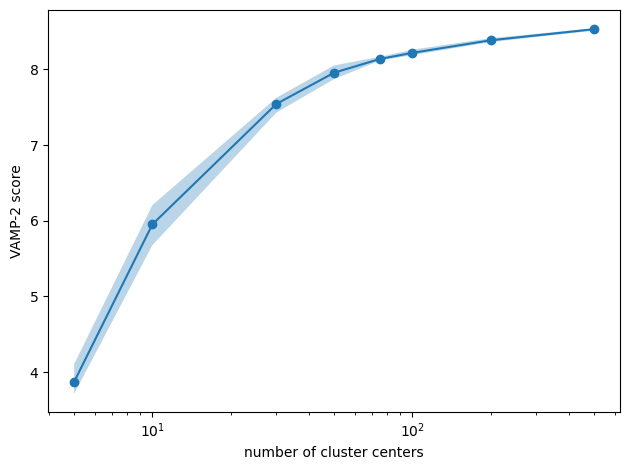

In [8]:
n_clustercenters = [5, 10, 30, 50, 75, 100, 200, 500][::-1]
fig, ax = my_msm.get_vamp_vs_k(n_clustercenters, tica)

If the calculation fails, there is something wrong with your MSM. Either you have too little transitions or there too many cvs in tica to have all the states well connected. Solutions:
+ Reduce the maximum number of clusters (drop 200 and 500) of `n_clustercenters` and see if you get a saturated curve.
+ Reduce the number of cvs that went into your TICA calculation.
+ Do more iterations of the string method.

## MSM Deeptime

Choose the number of clusters, `k`, for the clustering from the previous calculation. Also change n_proc to however many processors you can use.

In [9]:
k = 100
clusters = my_msm.k_means_cluster(
    tica, k, stride=1, max_iter=500, n_proc=8, seed=28101990
)

In [10]:
%%time
msm, weights = my_msm.get_msm(clusters)

CPU times: user 14.9 s, sys: 521 ms, total: 15.4 s
Wall time: 15.8 s


## CVs for projection

Make a `cv_proj` numpy array with shape (n_iteration * n_swarms_iterations, n_frames_per_iter, 2). n_frames_per_iter is usally 2 since you only record the value of the cvs at the begining and end of the swarm. The last dimesions are the cvs on which you would like to project your FES using the weights obtained from the msm. The FES is then the negative log of a *weighted* histogram of the projection cvs using the weights from the msm. The projection cvs can be anything that you can calculate for a structure, not necessarily the cvs of the string. In the example bellow it is the mean of two cvs.

In [11]:
my_cvs = [1,0] #IC gate for x axis, EC gate for y axis
cv_proj = cv_coordinates[:, :, my_cvs]

## Project FES

Do the projection and take log. You have to choose a bandwidth for the [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) of the histogram. It should be big enough to reduce noise but not so big to remove features. If you give `None`

In [12]:
bandwidth = 0.05
p_of_cv, extent = my_msm.get_kde(cv_proj, weights, bandwidth)
F0 = -np.log(p_of_cv)
F = F0 - F0.min()
F[F > 40] = np.nan

/tmp/ipykernel_13307/3473243697.py:3: RuntimeWarning: divide by zero encountered in log
  F0 = -np.log(p_of_cv)


## Plot FES

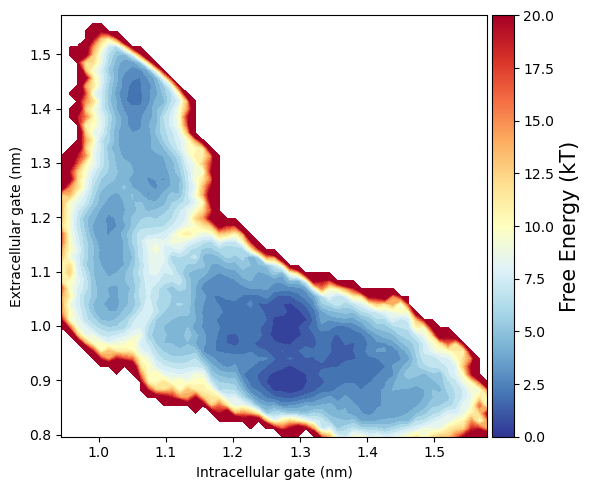

In [21]:
fig, ax = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=20,
    cbar_label="Free Energy (kT)",
    xlabel="Intracellular gate (nm)",
    ylabel="Extracellular gate (nm)",
    colorbar=True,
    cmap=plt.cm.get_cmap('RdYlBu_r')
)

fig.set_figheight(5)
fig.set_figwidth(6)
fig.tight_layout()
fig.show()

## Bootstrap to get error

The problem with calculating errors in MD is that most statistical techniques for this rely on the data being uncorrelated. MD data is most of the time highly correlated due to the proximity in time and starting structure. Correlated data generates artificially low error estimates. 

For this reason we use blocking. In our case we will use blocking+bootstrapping. This is very well explained in this [very usefull video](https://www.youtube.com/watch?v=gHXXGYIgasE&t=1854s) by prof. Giovanni Bussi.

The uncertainty is calculated as half of the interval containing 95% of the probability of the distribution of histograms generated in the bootstraps.

This part is probably going to be slow! Maybe it will go over night. It is actually doing len(blocks) * n_boot msms! The good things is that once you have figured out for your system (and similar systems) what is a reasonable number of blocks then you can just do `blocks=[my_reasonable_number_blocks]`.

In [22]:
run_error_calc = False

In [26]:
blocks =[2, 4, 8, 16, 32]

if run_error_calc: 
    errors = my_msm.get_error(
        cv_proj,
        clusters,
        extent,
        n_boot=200,
        bandwidth=0.05,
        nbin=55,
        blocks=blocks
    )

In [27]:
if run_error_calc:
    np.save("postprocessing/errors.npy", errors)
else:
    errors = np.load('postprocessing/errors.npy')

Choose the number of blocks that gives you a high error.

Note,`e_min` and `e_max` are choosen to remove the extremely high or low values of error that are generated due to poor sampling or high free energy. These regions of the "free error surface" are not what we care about and thus we remove it from the statistic and the visualization.

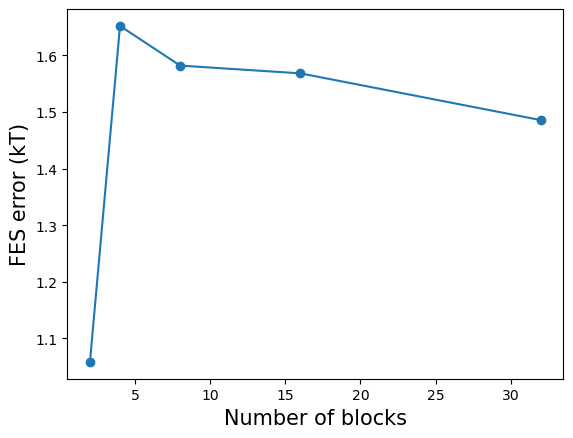

In [28]:
e_max = 6
e_min = 1.0e-03
e = errors.copy()
e[e > e_max] = np.nan
e[e <= e_min] = np.nan
_ = plt.plot(np.array(blocks), np.nanmean(e, axis=(1, 2)), marker="o")
_ = plt.xlabel("Number of blocks", size=15)
_ = plt.ylabel("FES error (kT)", size=15)

From the previous plot you can see which is the adequate number of blocks that low but still gives you the plateauing (or highest) error.

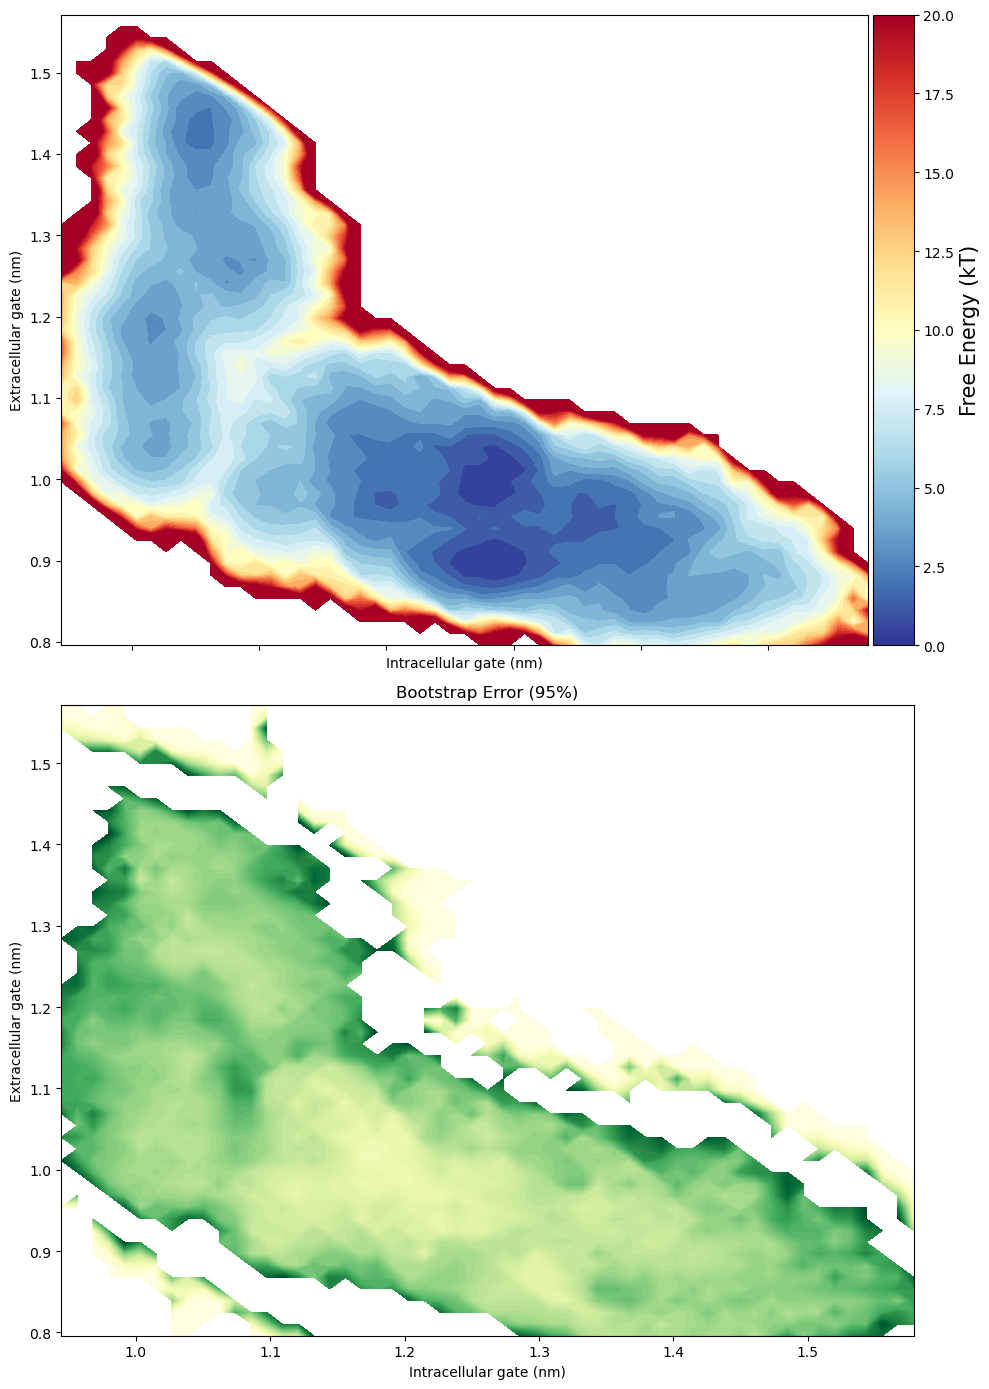

In [37]:
number_blocks = 8
f_max = 20
e_max = 3
e_min = 1.0e-03

e = errors[blocks.index(number_blocks)].copy()
e[e > e_max] = np.nan
e[e <= e_min] = np.nan

fig, ax = plt.subplots(2, 1, figsize=(10, 14), sharex=True, sharey=True)
_ = my_msm.plot_2D_heatmap(
    F,
    extent,
    f_max=20,
    cbar_label="Free Energy (kT)",
    xlabel="Intracellular gate (nm)",
    ylabel="Extracellular gate (nm)",
    fig=fig,
    ax=ax[0],
    colorbar=True,
    cmap=plt.cm.get_cmap('RdYlBu_r')
)
_ = my_msm.plot_2D_heatmap(
    e,
    extent,
    f_max=e_max,
    cbar_label="FES Uncertainty (kT)",
    xlabel="Intracellular gate (nm)",
    ylabel='Extracellular gate (nm)',
    cmap=plt.cm.YlGn,
    fig=fig,
    ax=ax[1],
)
ax[1].set_title("Bootstrap Error (95%)")
fig.tight_layout()
fig.show()